# <center>Welcome to 21cmFirstCLASS Notebook #4!</center>
### <center>By J. Flitter and S. Libanore</center>

21cmFirstCLASS is an extension of the popular 21cmFAST code that interfaces with CLASS to generate initial conditions consistent with the input cosmological model. These initial conditions can be set during the time of recombination, allowing one to compute the 21cm signal (and its spatial fluctuations) throughout the dark ages, as well as in the proceeding cosmic dawn and reionization epochs, just like in the standard 21cmFAST.

#### Summary of previous notebooks
- In Notebook #1, you learned how to install 21cmFirstCLASS and its dependencies, how to run the code for basic settings, and how to plot easily the simulation outputs.

- In Notebook #2, you learned about the new physical features (in &Lambda;CDM cosmology) that have been introduced to 21cmFirstCLASS and how to restore conditions similar to the original 21cmFAST.

- In Notebook #3, you learned how to study exotic models of dark matter (fuzzy dark matter and scattering dark matter) with 21cmFirstCLASS.

#### In this notebook you will learn how to...
- Install the code and all the dependencies it requires

- Compute the noise of the HERA experiment (with 21cmSense) and plot it on top of the 21cm power spectrum 

- Understand how to change the specifics of the experiment 

## Installation

To run this notebook, make sure you have 21cmSense installed in your 21cmFirstCLASS environment. You can download it by running in the terminal the following lines.
  ```python
  git clone https://github.com/rasg-affiliates/21cmSense.git
  cd 21cmSense/
```
21cmSense by default displays progress bars throughout each run.
If you don't want to show them, we recommend prior to the installation to set "PROGRESS = False" in the module
  ```python
config.py 
  ```   
Once this is done, run in the terminal
  ```python
  pip install . 
```

## General definitions

In [1]:
# Import the packages required for this tutorial
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

import py21cmfast as p21c # To run 21cmFirstCLASS (21cmFAST)
from py21cmfast import plotting # For plotting global signals, coeval boxes, lightcone boxes and power spectra
import py21cmfast.power_spectrum as ps # Calculate power spectrum from the lightcone

It is VERY recommended for 21cmFirstCLASS users to have the 'latex' package installed in the same python environment where 21cmFirstCLASS is installed. <br>
If you have latex installed then you may run the next cell, otherwise do not run it as it will raise errors and no plots in this tutorial will be shown!

In [2]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts

Define the color palette (this combination is good for colorblindness).

In [3]:
colors =  ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

## Compute the 21cm power spectrum $\Delta_{21}^2(k,z)$

To get a feeling for how much information we can obtain from HERA, we first need to compute the 21cm power spectrum 
$\Delta_{21}^2(k,z)$. Before we do that we run 21cmFirstCLASS to get the lightcone box at cosmic dawn. <br>
You should already be familiar with the settings of 21cmFirstCLASS by now, if not you can check Notebooks #1 and #2.
### Important Note!
To speed up the computation we use a rather small box with low resolution. Altough these settings are fine to obtain the correct global history, they are inadequate for studying the fluctuations of the box, or the power spectrum. Make sure to increase BOX_LEN and HII_DIM for reliable simulation of the power spectrum!

In [4]:
user_params = {"BOX_LEN": 100, 
               "HII_DIM": 25, 
               "N_THREADS": 6,
               "OUTPUT_AT_DARK_AGES": False, # We are not interested in having any output during the dark ages in this tutorial
               "EVALUATE_TAU_REIO": False} # Since we don't study the CMB power spectrum in this tutorial, we do not calculate tau_reio from the simulation

cosmo_params = {"hlittle": 0.6736, 
                "OMb": 0.0493,
                "OMm": 0.3153, 
                "A_s": 2.1e-9, 
                "POWER_INDEX": 0.9649, 
                "tau_reio": 0.0544, 
                }

flag_options = {"USE_MINI_HALOS": False, } # if False, popIII stars are not included - Note: if set to True, the runtime increases significantly!

astro_params = {} # We assume the default astrophysical parameters of 21cmFAST/21cmFirstCLASS

lightcone = p21c.run_lightcone(redshift = 6., 
                               random_seed = 1,
                               regenerate = True, 
                               write = False, 
                               user_params = user_params,
                               astro_params = astro_params,
                               flag_options = flag_options,
                               cosmo_params = cosmo_params) ;

Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|█████████████| 84/84 [00:33<00:00,  2.47redshift/s]


Now that we have the lightcone box we can compute the 21cm power spectrum.

In computing $\Delta_{21}^2(k,z)$, we divide the lightcone box according to the experimental frequency bands of HERA, which observes between 50 and 225 MHz with 8 MHz bandwidth.

In [5]:
fmin = 50.
fmax = 225.
bandwidth = 8.
freq_bands_boundaries = np.arange(fmin,fmax+bandwidth,bandwidth); freq_bands_boundaries[-1] = fmax

# compute the power spectrum in HERA bands
power_spectrum_HERA = ps.lightcone_power_spectrum(lightcone,
                                                  freq_bands_boundaries = freq_bands_boundaries) ; 

## Compute HERA noise with 21cmSense

Below we compute HERA's sensitivity to the 21cm power spectrum with the 21cmSense package.

To allow a convenient interface with 21cmSense, 21cmFirstCLASS works with the following module
  ```python
    experiment.py
  ```
We thus need to import the following.

In [6]:
# import the following function from the experiment module
from py21cmfast.experiment import run_21cmSense

# 21cmSense makes use of the astropy package, for which we need to import the following modules
from astropy import units as un
from astropy.cosmology.units import littleh
from astropy.cosmology import Planck18

### Set parameters for the 21cmSense calculation
The sensitivity of HERA depends on many parameters. We list below the most relevant ones you may be interested in playing with. Others are described in the 21cmSense documentation.

First, let's define the antennae configuration of HERA. HERA is shaped as an hexagon, and its sensitivity is set by the number of antennas and the separation between them. The following values correspond to the future full-HERA experiment.

In [7]:
hex_num = 11 # number of antennas along each of the hexagon outermost sides
dishsize = 14*un.m # diameter of each antenna
separation = 14*un.m # separation between adjacent antennae within a given row
row_separation = (14.*np.sin(np.pi/3.))*un.m # separation between two antenna rows

# Note that the above specifications define a packed hexagonal grid

We now define the parameters required by 21cmSense. In 21cmFirstCLASS, we can easily set the 21cmSense parameters with a single dictionary.

In [8]:
# Initialization of the dictionary for the 21cmSense parameters
Sense_params = {}

The following parameters must be specified for the 21cmSense calculation.

In [9]:
Sense_params["dish_size"] = dishsize # diameter of each antenna 
Sense_params["hex_num"] = hex_num # number of antennas along each of the hexagon outermost sides

All the following parameters are optional. If they are not specified, 21cmSense takes the default value.

In [10]:
Sense_params["separation"] = separation # separation between adjacent antennae within a given row
Sense_params["row_separation"] = row_separation # separation between two antenna rows

Sense_params["Trcv"] = 100.*un.K # temperature of the receiver, it sets the instrumental noise 
Sense_params["n_days"] = 540 # how many days in the observation run
Sense_params["time_per_day"] = 6.*un.hour # how much time observed per day 
Sense_params["bandwidth"] = bandwidth*un.MHz # frequency resolution, it should match the same bandwidth you used to compute the power spectrum 
Sense_params["n_channels"] = 82 # number of channels used to observe each bandwidth; together with it, sets the max k_parallel that can be observed

# Foreground model, default parameters are based on arXiv:1609.08705
Sense_params["tsky_amplitude"] = 60.*un.K # foreground brightness temperature at the pivot frequency
Sense_params["tsky_ref_freq"] = 300.*un.MHz # pivot frequency 
Sense_params["spectral_index"] = 2.55 # slope of the foreground frequency dependence

To compute the noise measured by HERA, 21cmSense has to receive $\Delta_{21}^2(k,z)$ as an input. This is because on large scales, the noise is dominated by 'cosmic variance', namely $\Delta_{21}^2(k,z)$.

For consistency, we pass 21cmSense the power spectrum we have previously computed.

In [11]:
Sense_params["power_spectrum"] = power_spectrum_HERA

In addition, 21cmSense can receive a cosmo object from astropy as an input. This is needed for 21cmSense in order to convert frequency/redshift to $k_{||}$. For consistency, we pass the input cosmological parameters we used for the 21cmFirstCLASS simulation.

In [12]:
Sense_params["cosmo"] = Planck18.clone(H0=100*power_spectrum_HERA.cosmo_params.hlittle,
                                       Om0=power_spectrum_HERA.cosmo_params.OMm,
                                       Ob0=power_spectrum_HERA.cosmo_params.OMb)

Finally, to avoid contaminated $k$ modes due to foreground, there are two more important parameters in 21cmSense:

* <b>foreground_model</b>: type of foreground scenario to consider. Can be either 'moderate' or 'optimistic'.
* <b>horizon_buffer</b>: the foreground avoidance procedure removes the k-modes beyond the horizon wedge (which are the most contaminated ones), but also some extra modes in the buffer, to be on the safe side.

In [13]:
Sense_params["foreground_model"] = "moderate"
Sense_params["horizon_buffer"] = 0.1*littleh/un.Mpc ; 

### Run 21cmSense
Once you have set the parameters, you are ready to run 21cmSense. This is very easy in 21cmFirstCLASS and can be done with a single line. <br> 

In [14]:
# Run 21cmSense!
HERA_noise_data = run_21cmSense(Sense_params) ;

21cmSense: 100%|██████████████████████████| 19/19 [00:56<00:00,  2.98s/redshift]


### Explore the output of 21cmSense
The output of 'run_21cmSense' is a special object with the following fields.

In [15]:
list(vars(HERA_noise_data).keys())

['power_spectrum', 'z_values', 'signal', 'noise', 'k_noise', 'sensitivities']

These are their meaning:
* <b>power_spectrum</b>: This returns the same 'POWER_SPECTRUM' object that was given to 21cmSense an input. In our case, it is the same as 'power_spectrum_HERA'.
* <b>z_values</b>: These values match the redshift chunks used for calculating the 21cm power spectrum. In our case, they (almost) match the center of HERA's frequency bands (the smaller the cell size, the better the matching is).
* <b>k_noise</b>: This is a dictionary. For each 'z' value in 'z_values' it returns the wavenumbers in which the noise was estimated. Note that the values of these wavenumbers vary between different chunks! In fact, the $n$'th entry in 'k_noise' is

\begin{eqnarray}
k_n&=&\frac{2\pi\nu_{21}H\left(z\right)}{c\,\left(1+z\right)^2B}n,\qquad n=1,\dots,N
\\&\approx&0.045n\,\left(\frac{\Omega_{m}h^{2}}{0.143}\right)^{1/2}\left(\frac{8\,\mathrm{MHz}}{B}\right)\left(\frac{10}{1+z}\right)^{1/2}\,\mathrm{Mpc}^{-1}
\end{eqnarray}

&emsp;&emsp;&ensp;where B is the experiment's bandwidth (8 MHz in HERA), and $N$ is the number of different channel per frequency band ('n_channels', 82 in HERA).
* <b>noise</b>: This is a dictionary. For each 'z' value in 'z_values' it returns the noise values that correspond to 'k_noise'.
* <b>signal</b>: This is a dictionary. For each 'z' value in 'z_values' it returns the signal values (namely $\Delta_{21}^2(k,z)$) that correspond to 'k_noise'. Note that this dictionary does not contain the same values as in 'power spectrum' due to the different $k$ bins.
* <b>sensitivities</b>: This is a dictionary. For each 'z' value in 'z_values' it returns a 'Sensitivity' object used by 21cmSense.

Let us print the 'z_values' in which the noise was estimated, and their corresponding frequencies.

In [16]:
z_values = HERA_noise_data.z_values
print(f'z_values = {z_values}')

f_21 = 1420.40575177 # MHz - frequency of the 21cm line
f_values = f_21/(1.+z_values)
print(f'f_values = {f_values}')

z_values = [ 6.17376642  6.47581975  6.80442721  7.16325145  7.55666116  7.98990982
  8.46937168  9.00285741  9.60004292 10.27306152 11.03733688 11.91277956
 12.92554659 14.11069949 15.51634595 17.21033015 19.29151074 21.90977019
 25.30381022]
f_values = [198. 190. 182. 174. 166. 158. 150. 142. 134. 126. 118. 110. 102.  94.
  86.  78.  70.  62.  54.]


You can also extract information on the detector from the 21cmSense objects.

For example, we can print the total number of antennae that was assumed in the 21cmSense calculation (corresponds to the total number of antennae in a hexagonal configuration of base 11).

In [17]:
z = z_values[0] # doesn't really matter which redshift we consider
baselines = HERA_noise_data.sensitivities[z].observation.observatory.baselines_metres
print(f'Total amount of antennae: {baselines.shape[0]}')

Total amount of antennae: 331


We can also display the antennae configuration using the following lines.
#### Note
In reality, each one of the presented dots (an antenna) is larger, as according to our specifications the antennae are packed. This can be fixed by specifying a large 's' argument in 'ax.scatter'.

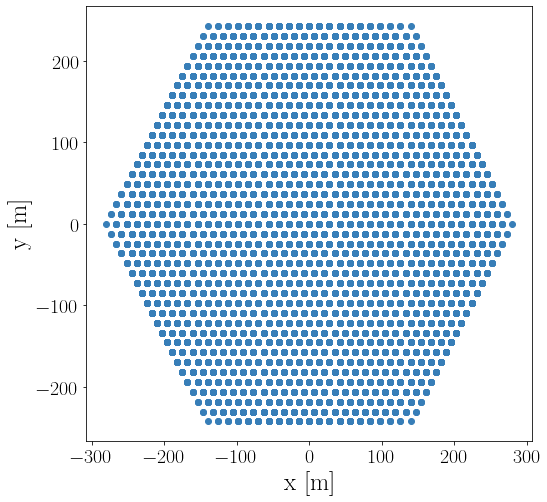

In [18]:
# x and y coordinates of the antennae
x_coords = baselines[:,:,0]
y_coords = baselines[:,:,1]

# Plot the antennae configuration
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(x_coords,y_coords)

# Prettify the plot
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlabel(xlabel='x [m]',fontsize=25)
ax.set_ylabel(ylabel='y [m]',fontsize=25);

## Plot the noise of HERA

In order to visualize the noise of HERA, it's best to compare it with the signal that HERA aims to detect. To do that, we use the 'plot_1d_power_spectrum' function of 21cmFirstCLASS which allows us to plot $\Delta_{21}^2$ as a function of either $z$ or $k$. In order to display the estimated noise from HERA, pass this function a 'noise_data' argument, as we show below.

#### Note
We recommend of showing the power spectrum as a function of frequency (rather redshift), as this corresponds better to what HERA measures!
### Important Note!
The following power spectrum plots are imprecise, especially when we plot the power spectrum as a function of $k$, as we have set a small box with very low resolution!
In order to achieve the correct power spectrum, you must increase BOX_LEN and HII_DIM!

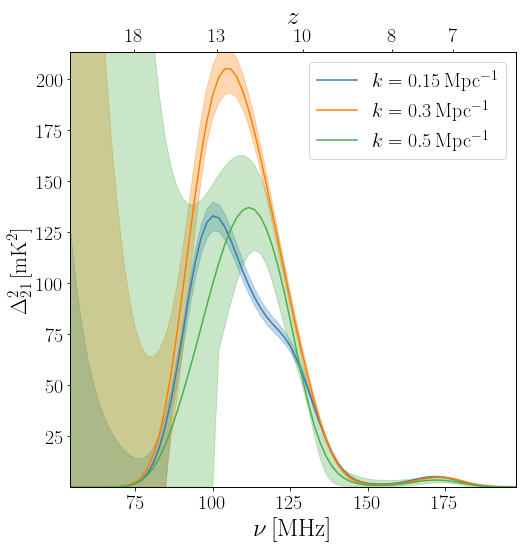

In [19]:
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_HERA, k=0.15, x_kind = 'frequency',
                                          smooth=True,
                                          noise_data=HERA_noise_data,
                                          label=r'$k = 0.15\,{\rm Mpc^{-1}}$')

fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_HERA, k=0.3, x_kind = 'frequency',
                                          smooth=True,
                                          noise_data=HERA_noise_data,
                                          label=r'$k = 0.3\,{\rm Mpc^{-1}}$',
                                          ax=ax)

fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_HERA, k=0.5, x_kind = 'frequency',
                                          smooth=True,
                                          noise_data=HERA_noise_data,
                                          redshift_axis_on_top=True,
                                          label=r'$k = 0.5\,{\rm Mpc^{-1}}$',
                                          ax=ax)

ax.set_ylabel(r'$\Delta^2_{21}\,[\mathrm{mK}^2]$')
ax.set_yscale('linear')

Regardless of the shape and amplitude of the power spectrum, we see from the above plot that HERA is in general mostly sensitive to high frequencies (low redshifts) and to large scale (small $k$, as long we have not entered the horizon wedge/buffer). Below a critical frequency (which depends on scale), the noise diverges.

Default settings of 'plot_1d_power_spectrum' is to show the noise as shaded regions around the power spectrum. We can also show the noise in the form of error bars. Note that, in principle, this is more correct since HERA only observes a finite amount of frequency bands, controlled by the bandwidth of HERA.


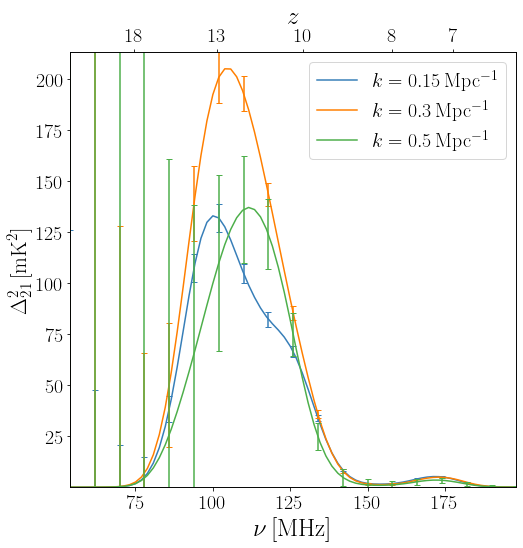

In [20]:
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_HERA, k=0.15, x_kind = 'frequency',
                                          smooth=True, 
                                          noise_data=HERA_noise_data,
                                          error_bars = True,
                                          label=r'$k = 0.15\,{\rm Mpc^{-1}}$')

fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_HERA, k=0.3, x_kind = 'frequency',
                                          smooth=True, 
                                          noise_data=HERA_noise_data,
                                          error_bars = True,
                                          label=r'$k = 0.3\,{\rm Mpc^{-1}}$',
                                          ax=ax)

fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_HERA, k=0.5, x_kind = 'frequency',
                                          smooth=True, 
                                          noise_data=HERA_noise_data,
                                          redshift_axis_on_top=True,
                                          error_bars = True,
                                          label=r'$k = 0.5\,{\rm Mpc^{-1}}$',
                                          ax=ax)

ax.set_ylabel(r'$\Delta^2_{21}\,[\mathrm{mK}^2]$')
ax.set_yscale('linear')

We can also show the noise when we plot the power spectrum as a function of $k$, for a specific frequency\redshift.
Since each frequency band of HERA accesses different values of $k_{||}$, 'plot_1d_power_spectrum' does not interpolate the noise as it did in the above plots, but rather finds the closest frequency\redshift in the noise data (note the displayed warning).

/Users/jordanflitter/opt/anaconda3/envs/21cmFast_ENV/lib/python3.9/site-packages/21cmFAST-3.1.3-py3.9-macosx-10.9-x86_64.egg/py21cmfast/plotting.py:903: UserWarning: You attempt to plot noise for a given frequency, but your noise data doesn't contain that frequency! Finding the closest frequency in the noise data
  warnings.warn("You attempt to plot noise for a given frequency,"


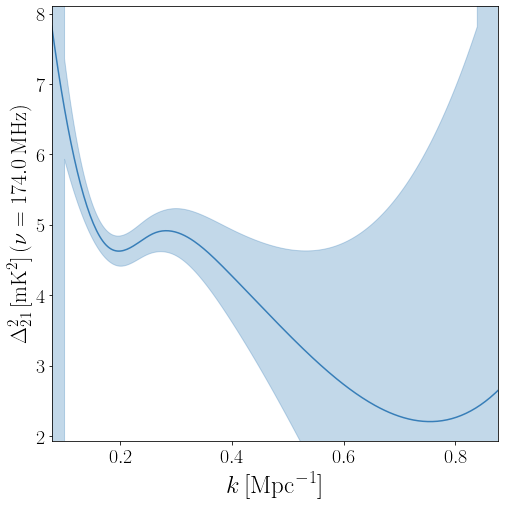

In [21]:
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_HERA, nu=175,
                                          smooth=True, 
                                          noise_data=HERA_noise_data,
                                          ylog=False) ;

## Comparison with "optimistic" foreground scenario
The estimated noise we have previously computed highly depends on the assume foreground model (we have assumed a "moderate" foreground scenario).

We now run 21cmSense for the second time, this time with an "optimistic" foreground scenario.

In [22]:
Sense_params["foreground_model"] = "optimistic" 

HERA_noise_data_optimistic = run_21cmSense(Sense_params) ; 

21cmSense: 100%|██████████████████████████| 19/19 [00:57<00:00,  3.02s/redshift]


And compare the noise of HERA in the two scenarios.

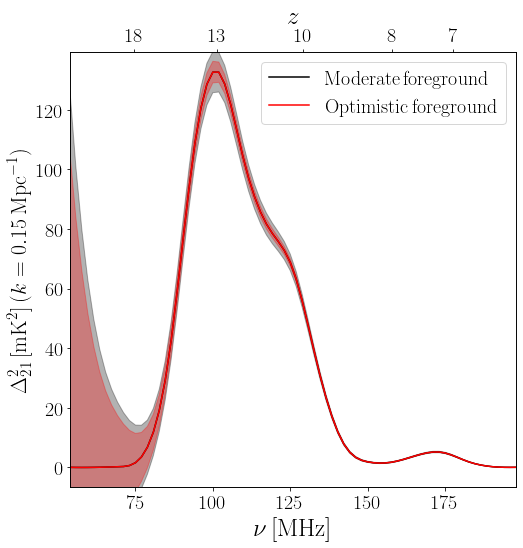

In [23]:
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_HERA, k=0.15,x_kind = 'frequency',
                                          smooth=True,
                                          noise_data=HERA_noise_data,
                                          ylog=False,
                                          color = 'k', 
                                          label=r'$\rm Moderate\,foreground$')

fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_HERA, k=0.15, x_kind = 'frequency',
                                          smooth=True,
                                          noise_data=HERA_noise_data_optimistic,
                                          redshift_axis_on_top=True,
                                          ylog=False,
                                          color = 'r', 
                                          ax = ax,
                                          label=r'$\rm Optimistic\,foreground$')

Clearly, the noise is smaller for the "optimistic" foreground scenario.

## Great, you reached the end of Notebook #4!

This concludes our tutorial on 21cmFirstCLASS and its applications. <br>
From now on, all the issues are on you!

#### If you have questions or you find bugs, feel free to email us!
jordanf@post.bgu.ac.il

libanore@bgu.ac.il